# Computational Cognitive Neuroscience

## Assignment 2 

#### Douwe van Erp (s4258126) & Arianne Meijer - van de Griend (s4620135)

In [1]:
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
import utils
import numpy as np
from chainer.cuda import to_cpu
from chainer.dataset import concat_examples
import matplotlib.pyplot as plt

### Definition of the different models

The code below contains 3 classes for the fully connected neural networks with 1, 2 and 3 layers respectively.

In [2]:
class FCNN1(Chain):
    def __init__(self, n_out):
        super(FCNN1, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_out)

    def __call__(self, x):
        y = self.l1(x)
        return y

class FCNN2(Chain):
    def __init__(self, n_units, n_out):
        super(FCNN2, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_units)
            self.l2 = L.Linear(None, n_out)

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        y = self.l2(h1)
        return y

class FCNN3(Chain):
    def __init__(self, n_units, n_out):
        super(FCNN3, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_units)
            self.l2 = L.Linear(None, n_units)
            self.l3 = L.Linear(None, n_out)

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        y = self.l2(h2)
        return y

The code below contains the definition of the class representing the convolutional neural network as described in the assignment.

In [3]:
class CNN(Chain):
    def __init__(self, n_units, n_out):
        super(CNN, self).__init__()
        with self.init_scope():
            # 5 output channels, kernel size of 5, stride of 1, padding of 0
            self.l_conv = L.Convolution2D(None, 5, 5, 1, 0)
            self.l_fc = L.Linear(None, n_units)
            self.l_out = L.Linear(None, n_out)

    def __call__(self, x):
        h1 = F.max_pooling_2d(self.l_conv(x), 5, 1, 0)
        h2 = F.relu(self.l_fc(h1))
        y = self.l_out(h2)
        return y

The code below specifies the class for the extended model.
For the extended model, we have added a dropout layer to the CNN, because this one performed best.
We chose a dropout layer because it regulates the model even more and prevents it from overfitting.
The dropout layer was added after the maxpooling, since it will then drop the pooled features extracted with the convolutional layer. 

In [4]:
# Model iwth additional components (e.g. one of dropout, batch normalization, other activation functions, etc.).
class ENN(Chain):
    def __init__(self, n_units, n_out):
        super(ENN, self).__init__()
        with self.init_scope():
            # 5 output channels, kernel size of 5, stride of 1, padding of 0
            self.l_conv = L.Convolution2D(None, 5, 5, 1, 0)
            self.l_fc = L.Linear(None, n_units)
            self.l_out = L.Linear(None, n_out)
            self.gamma = 0.0
            self.beta = 1.0

    def __call__(self, x):
        h1 = F.dropout(F.max_pooling_2d(self.l_conv(x), 5, 1, 0), ratio=0.5)
        h2 = F.relu(self.l_fc(h1))
        y = self.l_out(h2)
        return y

### Performance deep neural networks

In [5]:
def train_model(model):
    max_epoch = 20
    train_loss = []
    val_loss = []
    
    while train_iter.epoch < max_epoch:
    
        # Next minibatch
        train_batch = train_iter.next()
        image_train, target_train = concat_examples(train_batch)
    
        # Feedforward pass
        prediction_train = model(image_train)
    
        # Softmax cross entropy loss
        loss = F.softmax_cross_entropy(prediction_train, target_train)
    
        # Backpropagation
        model.cleargrads()
        loss.backward()
    
        # Update all the trainable paremters
        optimizer.update()
    
        # Check the validation accuracy of prediction after every epoch
        if train_iter.is_new_epoch:
    
            # Display the training loss
            print('epoch:{:02d} train_loss:{:.04f} '.format(train_iter.epoch, float(to_cpu(loss.data))), '')
    
            train_loss.append(float(to_cpu(loss.data)))
    
            test_losses = []
            test_accuracies = []
            while True:
                test_batch = test_iter.next()
                image_test, target_test = concat_examples(test_batch)
    
                # Forward pass
                prediction_test = model(image_test)
    
                # Calculate the loss
                loss_test = F.softmax_cross_entropy(prediction_test, target_test)
                test_losses.append(to_cpu(loss_test.data))
    
                # Calculate the accuracy
                accuracy = F.accuracy(prediction_test, target_test)
                accuracy.to_cpu()
                test_accuracies.append(accuracy.data)
    
                if test_iter.is_new_epoch:
                    test_iter.epoch = 0
                    test_iter.current_position = 0
                    test_iter.is_new_epoch = False
                    test_iter._pushed_position = None
                    break
    
            print('val_loss:{:.04f} val_accuracy:{:.04f}'.format(np.mean(test_losses), np.mean(test_accuracies)))
            
            val_loss.append(np.mean(test_losses))
            
    return max_epoch, train_loss, val_loss

In [6]:
def plot_training(epoch, train_loss, val_loss, title): 
    x = range(epoch)          
    fig = plt.figure()
    ax = plt.subplot(111)
    
    ax.plot(x, val_loss, 'r', label="Validation")
    ax.plot(x, train_loss, 'b', label="Training")
    
    plt.xlabel('Epoch')
    plt.xticks(range(epoch))
    plt.ylabel('Loss')
    plt.title(title)
    ax.legend()
    plt.show()

In [7]:
def plot_comparison(epoch, results, title): 
    x = range(epoch)          
    fig = plt.figure()
    ax = plt.subplot(111)
    
    colors = ['r','g','b','y']
    i=0
    for val, train, label in results:
        c = colors[i]
        ax.plot(x, val, c, label="Validation " + label, linestyle='solid')
        ax.plot(x, train, c, label="Training" + label, linestyle='dashed')
        i+=1
        
    plt.xlabel('Epoch')
    plt.xticks(range(epoch))
    plt.ylabel('Loss')
    plt.title(title)
    ax.legend()
    plt.show()

In [8]:
# Load data and iterators
train, test = utils.get_mnist(n_train=100, n_test=100, n_dim=1, with_label=True)
results = []

('epoch:01 train_loss:2.1129 ', '')
val_loss:2.0475 val_accuracy:0.3838
('epoch:02 train_loss:1.7641 ', '')
val_loss:1.8417 val_accuracy:0.5771
('epoch:03 train_loss:1.5585 ', '')
val_loss:1.6804 val_accuracy:0.6484
('epoch:04 train_loss:1.3959 ', '')
val_loss:1.5499 val_accuracy:0.6973
('epoch:05 train_loss:1.3241 ', '')
val_loss:1.4420 val_accuracy:0.7080
('epoch:06 train_loss:1.2399 ', '')
val_loss:1.3545 val_accuracy:0.7256
('epoch:07 train_loss:1.1479 ', '')
val_loss:1.2829 val_accuracy:0.7324
('epoch:08 train_loss:1.1194 ', '')
val_loss:1.2218 val_accuracy:0.7441
('epoch:09 train_loss:1.0522 ', '')
val_loss:1.1703 val_accuracy:0.7461
('epoch:10 train_loss:1.1972 ', '')
val_loss:1.1249 val_accuracy:0.7490
('epoch:11 train_loss:0.8618 ', '')
val_loss:1.0868 val_accuracy:0.7559
('epoch:12 train_loss:0.8565 ', '')
val_loss:1.0528 val_accuracy:0.7588
('epoch:13 train_loss:0.8167 ', '')
val_loss:1.0215 val_accuracy:0.7607
('epoch:14 train_loss:0.9183 ', '')
val_loss:0.9951 val_accuracy

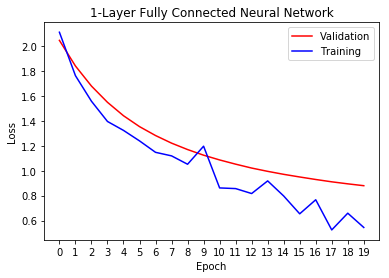

In [9]:
train_iter = iterators.SerialIterator(train, batch_size=32, shuffle=True)
test_iter = iterators.SerialIterator(test, batch_size=32, repeat=False, shuffle=False)

model = FCNN1(10)
optimizer = optimizers.SGD()
optimizer.setup(model)

epoch, train_loss, val_loss = train_model(model)
plot_training(epoch, train_loss, val_loss, '1-Layer Fully Connected Neural Network')
results.append((val_loss, train_loss, "FCNN1"))

('epoch:01 train_loss:2.0805 ', '')
val_loss:2.1597 val_accuracy:0.3291
('epoch:02 train_loss:1.9248 ', '')
val_loss:2.0251 val_accuracy:0.5264
('epoch:03 train_loss:1.8997 ', '')
val_loss:1.8847 val_accuracy:0.6211
('epoch:04 train_loss:1.6698 ', '')
val_loss:1.7418 val_accuracy:0.6709
('epoch:05 train_loss:1.4376 ', '')
val_loss:1.6037 val_accuracy:0.6973
('epoch:06 train_loss:1.2810 ', '')
val_loss:1.4812 val_accuracy:0.7148
('epoch:07 train_loss:1.0908 ', '')
val_loss:1.3752 val_accuracy:0.7178
('epoch:08 train_loss:0.9598 ', '')
val_loss:1.2829 val_accuracy:0.7207
('epoch:09 train_loss:1.1754 ', '')
val_loss:1.2032 val_accuracy:0.7266
('epoch:10 train_loss:1.1010 ', '')
val_loss:1.1345 val_accuracy:0.7344
('epoch:11 train_loss:0.8052 ', '')
val_loss:1.0759 val_accuracy:0.7402
('epoch:12 train_loss:0.7069 ', '')
val_loss:1.0245 val_accuracy:0.7432
('epoch:13 train_loss:0.6705 ', '')
val_loss:0.9810 val_accuracy:0.7490
('epoch:14 train_loss:0.6675 ', '')
val_loss:0.9430 val_accuracy

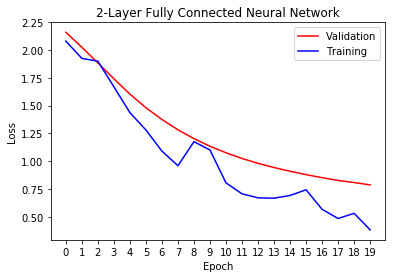

In [10]:
train_iter = iterators.SerialIterator(train, batch_size=32, shuffle=True)
test_iter = iterators.SerialIterator(test, batch_size=32, repeat=False, shuffle=False)
model = FCNN2(64,10)
optimizer = optimizers.SGD()
optimizer.setup(model)

epoch, train_loss, val_loss = train_model(model)
plot_training(epoch, train_loss, val_loss, '2-Layer Fully Connected Neural Network')
results.append((val_loss, train_loss, "FCNN2"))

('epoch:01 train_loss:3.8195 ', '')
val_loss:3.8761 val_accuracy:0.1660
('epoch:02 train_loss:3.3237 ', '')
val_loss:3.4259 val_accuracy:0.2129
('epoch:03 train_loss:2.7606 ', '')
val_loss:2.7352 val_accuracy:0.3096
('epoch:04 train_loss:2.2558 ', '')
val_loss:2.2428 val_accuracy:0.4756
('epoch:05 train_loss:1.7941 ', '')
val_loss:1.9780 val_accuracy:0.5537
('epoch:06 train_loss:1.7060 ', '')
val_loss:1.7897 val_accuracy:0.5811
('epoch:07 train_loss:1.4114 ', '')
val_loss:1.6264 val_accuracy:0.6279
('epoch:08 train_loss:1.1706 ', '')
val_loss:1.5026 val_accuracy:0.6191
('epoch:09 train_loss:1.2286 ', '')
val_loss:1.3697 val_accuracy:0.6484
('epoch:10 train_loss:1.0694 ', '')
val_loss:1.2497 val_accuracy:0.6738
('epoch:11 train_loss:0.9733 ', '')
val_loss:1.1573 val_accuracy:0.6855
('epoch:12 train_loss:0.8603 ', '')
val_loss:1.0959 val_accuracy:0.6738
('epoch:13 train_loss:0.8342 ', '')
val_loss:1.0238 val_accuracy:0.6904
('epoch:14 train_loss:0.9550 ', '')
val_loss:0.9788 val_accuracy

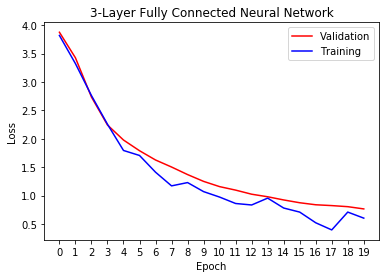

In [11]:
train_iter = iterators.SerialIterator(train, batch_size=32, shuffle=True)
test_iter = iterators.SerialIterator(test, batch_size=32, repeat=False, shuffle=False)
model = FCNN3(64,10)
optimizer = optimizers.SGD()
optimizer.setup(model)

epoch, train_loss, val_loss = train_model(model)
plot_training(epoch, train_loss, val_loss, '3-Layer Fully Connected Neural Network')
results.append((val_loss, train_loss, "FCNN3"))

The three plots that show the training and validation loss for neural networks with 1, 2 and 3 layers are shown above.
These plots show that each network does train over time, because the loss gets smaller. It also shows that the models do not overfit, since the validation and training loss are very similar. 
This is also visible in the combined plot shown below.
The combined plot shows that the higher the number of layers, the better the network after enough epochs. More layers do cause a larger loss at the start of training, due to the extra random parameters.

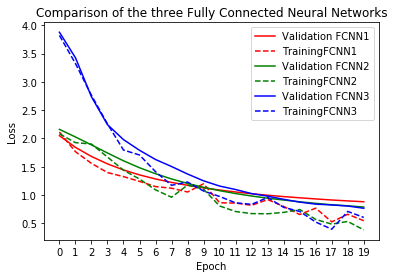

In [12]:
plot_comparison(epoch, results, "Comparison of the three Fully Connected Neural Networks")

### Performance convolutional neural network
TODO visualise (plot loss), interpret the results + report conclusions

('epoch:01 train_loss:1.8968 ', '')
val_loss:1.9023 val_accuracy:0.5674
('epoch:02 train_loss:1.4476 ', '')
val_loss:1.4795 val_accuracy:0.6406
('epoch:03 train_loss:0.8619 ', '')
val_loss:1.0541 val_accuracy:0.6846
('epoch:04 train_loss:0.7694 ', '')
val_loss:0.8293 val_accuracy:0.7627
('epoch:05 train_loss:0.6616 ', '')
val_loss:0.7097 val_accuracy:0.7822
('epoch:06 train_loss:0.4838 ', '')
val_loss:0.6044 val_accuracy:0.8203
('epoch:07 train_loss:0.4529 ', '')
val_loss:0.5478 val_accuracy:0.8281
('epoch:08 train_loss:0.2331 ', '')
val_loss:0.5090 val_accuracy:0.8418
('epoch:09 train_loss:0.3607 ', '')
val_loss:0.5286 val_accuracy:0.8096
('epoch:10 train_loss:0.3451 ', '')
val_loss:0.4804 val_accuracy:0.8389
('epoch:11 train_loss:0.2367 ', '')
val_loss:0.4335 val_accuracy:0.8574
('epoch:12 train_loss:0.1382 ', '')
val_loss:0.4279 val_accuracy:0.8506
('epoch:13 train_loss:0.1578 ', '')
val_loss:0.3744 val_accuracy:0.8711
('epoch:14 train_loss:0.3188 ', '')
val_loss:0.3850 val_accuracy

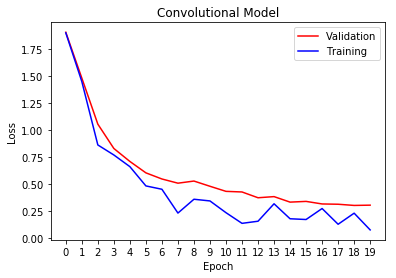

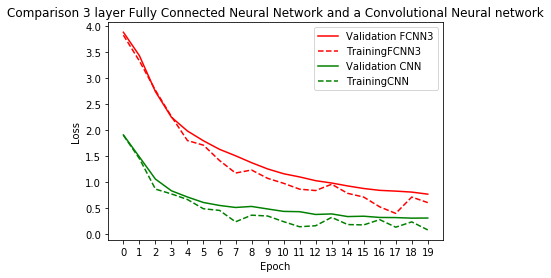

In [13]:
# Load data and iterators
train, test = utils.get_mnist(n_train=100, n_test=100, n_dim=3, with_label=True)
train_iter = iterators.SerialIterator(train, batch_size=32, shuffle=True)
test_iter = iterators.SerialIterator(test, batch_size=32, repeat=False, shuffle=False)

model = CNN(64,10)
optimizer = optimizers.SGD()
optimizer.setup(model)

epoch, train_loss, val_loss = train_model(model)
plot_training(epoch, train_loss, val_loss, 'Convolutional Model')
cnn_result = (val_loss, train_loss, 'CNN')
plot_comparison(epoch, [results[2],cnn_result], "Comparison 3 layer Fully Connected Neural Network and a Convolutional Neural network")

In the first graph shown above, the training and validation loss per epoch is shown. It is visible that the loss gets smaller per epoch of training and that the validation and training loss stay relatively similar. This means that the model gets better per epoch and does not overfit. 

The second graph shows how the Convolutional Neural Netowrk compares to the best fully connected network (3-layers). It is visible that the CNN is a lot better than the FCNN, both at the random initialisation (due to the small number of parameters) and after 20 epochs.

### Biological plausibility of convolution
Convolutional neural networks are known to be inspired by nature. 
The idea behind a convolutional layer is that neurons in the visual cortex have a specific area that they respond to; the receptive field.
Implementing this in a neural network causes that there are less neurons connected to each other, thus shrinking the amount of weights that need to be optimized in backpropagation.
To do that, however, it is necessary to find a way for multiple neuron outputs to be combined into one neuron input in the next layer.
This can, theoretically, be done in various ways, but the current preference is for a convolution.
To further decrease the number of parameters necessary to train in the neural network, the same convolution is used over the entire picture.
The choice of convolution is substantiated by the notion that a convolution mimics the activity of a neuron.
This means that the result of the convolutional layer in terms of activation is very similar to that of normal input neurons that have the same activation.
The difference is that the convolutional layer activation contains more detailed information than the, e.g. RGB, activation at the input level.

Thus the use of convolutions in deep neural networks is biologically plausible in the sense that it has a receptive field and neurons are combined in a sense that the output of the convolutional layer mimics neural activation.

However, there can still be a philosophical debate about to what extend the convolution calculation itself is a good representation of what happens in the brain.
Mathematically, it is possible to generate infinite different functions with the same input and output as a given function, so we can never really know for sure when looking solely at input-output behaviour.
Nevertheless, the current solution is a simple and elegant interpretation of what happens in the brain, on some level.
Considering that nature tends to find the simplest mathematical solution to a problem, it would not be suprising if this is close to the real solution of image processing in the brain.
Only with more research we can determine definitively whether convolution is biologically plausible or not.


### Performance extended model

('epoch:01 train_loss:2.0348 ', '')
val_loss:2.1386 val_accuracy:0.2383
('epoch:02 train_loss:1.9168 ', '')
val_loss:1.8828 val_accuracy:0.4209
('epoch:03 train_loss:1.4939 ', '')
val_loss:1.5875 val_accuracy:0.5068
('epoch:04 train_loss:1.0927 ', '')
val_loss:1.3162 val_accuracy:0.5850
('epoch:05 train_loss:1.0491 ', '')
val_loss:1.0991 val_accuracy:0.6562
('epoch:06 train_loss:0.6533 ', '')
val_loss:0.9813 val_accuracy:0.6768
('epoch:07 train_loss:0.7485 ', '')
val_loss:0.8564 val_accuracy:0.7090
('epoch:08 train_loss:0.5563 ', '')
val_loss:0.8057 val_accuracy:0.7256
('epoch:09 train_loss:0.4529 ', '')
val_loss:0.7264 val_accuracy:0.7480
('epoch:10 train_loss:0.6517 ', '')
val_loss:0.7047 val_accuracy:0.7676
('epoch:11 train_loss:0.3658 ', '')
val_loss:0.6389 val_accuracy:0.7861
('epoch:12 train_loss:0.4062 ', '')
val_loss:0.6267 val_accuracy:0.7793
('epoch:13 train_loss:0.3688 ', '')
val_loss:0.5387 val_accuracy:0.8086
('epoch:14 train_loss:0.2637 ', '')
val_loss:0.5522 val_accuracy

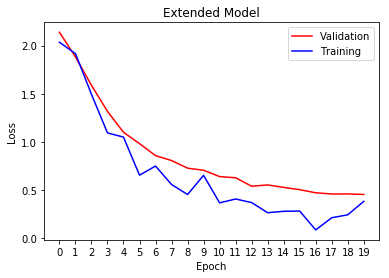

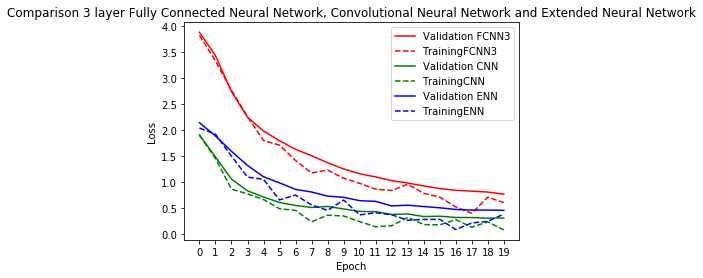

In [14]:
train_iter = iterators.SerialIterator(train, batch_size=32, shuffle=True)
test_iter = iterators.SerialIterator(test, batch_size=32, repeat=False, shuffle=False)

#TODO - naming
model = ENN(64,10)
optimizer = optimizers.SGD()
optimizer.setup(model)

epoch, train_loss, val_loss = train_model(model)
plot_training(epoch, train_loss, val_loss, 'Extended Model')
enn_result = (val_loss, train_loss, 'ENN')
plot_comparison(epoch, [results[2],cnn_result, enn_result], "Comparison 3 layer Fully Connected Neural Network, Convolutional Neural Network and Extended Neural Network")

The first graph above shows the training and validation loss of the extended model. It shows, like the graphs for the other models, that the model does train and does not overfit.

The second graph shows that the extended model does not improve the convolutional neural network. This makes sense, since a convolutional neural network is already heavily regulated and adding a dropout layer could cause it to underfit. Especially when training on small amounts of data and in such a small network.